# Stage 1: Initial EDA, Data Preprocessing, and Modeling
Goal: predict whether or not water is acceptable for human consumption (potability) based on its chemical characteristics.

Data source: [Kaggle Water Quality Dataset](https://www.kaggle.com/adityakadiwal/water-potability)

**This is a binary classification problem: the water can be acceptable for human consumption (potable) or not.**

In [1]:
import pandas as pd
import numpy as np
import boto3
import sagemaker

import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


In [2]:
bucket = '<INSERT BUCKET NAME HERE>'
input_prefix = 'input'
input_key = 'water_potability.csv'

region = 'us-west-2'

In [3]:
s3_input_uri = 's3://{}/{}/{}'.format(bucket, input_prefix, input_key)

In [4]:
df = pd.read_csv(s3_input_uri)
df.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


### EDA and Visualization

In [5]:
df.describe()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,2785.000000,3276.000000,3276.000000,3276.000000,2495.000000,3276.000000,3276.000000,3114.000000,3276.000000,3276.000000
mean,7.080795,196.369496,22014.092526,7.122277,333.775777,426.205111,14.284970,66.396293,3.966786,0.390110
std,1.594320,32.879761,8768.570828,1.583085,41.416840,80.824064,3.308162,16.175008,0.780382,0.487849
min,0.000000,47.432000,320.942611,0.352000,129.000000,181.483754,2.200000,0.738000,1.450000,0.000000
25%,6.093092,176.850538,15666.690297,6.127421,307.699498,365.734414,12.065801,55.844536,3.439711,0.000000
50%,7.036752,196.967627,20927.833607,7.130299,333.073546,421.884968,14.218338,66.622485,3.955028,0.000000
75%,8.062066,216.667456,27332.762127,8.114887,359.950170,481.792304,16.557652,77.337473,4.500320,1.000000
max,14.000000,323.124000,61227.196008,13.127000,481.030642,753.342620,28.300000,124.000000,6.739000,1.000000


In [6]:
df.shape

(3276, 10)

In [7]:
df['Potability'].value_counts()

0    1998
1    1278
Name: Potability, dtype: int64

In [8]:
df['Potability'].isna().sum()

0

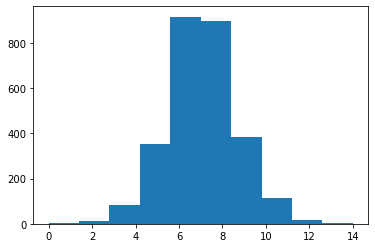

In [9]:
plt.figure()
plt.hist(df['ph'])
plt.show()

In [10]:
df['ph'].isna().sum()

491

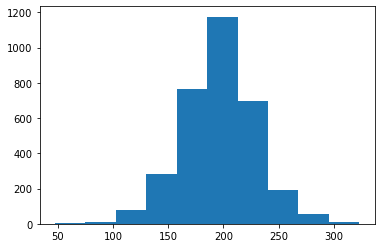

In [11]:
plt.figure()
plt.hist(df['Hardness'])
plt.show()

In [12]:
df['Hardness'].isna().sum()

0

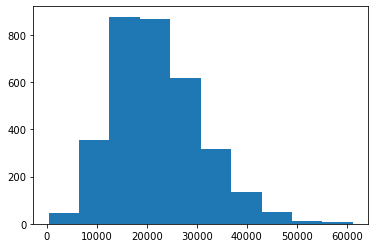

In [13]:
plt.figure()
plt.hist(df['Solids'])
plt.show()

In [14]:
df['Solids'].isna().sum()

0

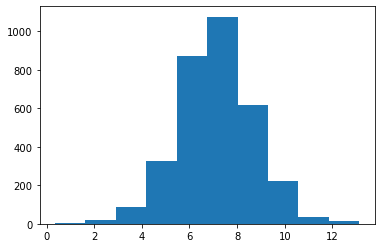

In [15]:
plt.figure()
plt.hist(df['Chloramines'])
plt.show()

In [16]:
df['Chloramines'].isna().sum()

0

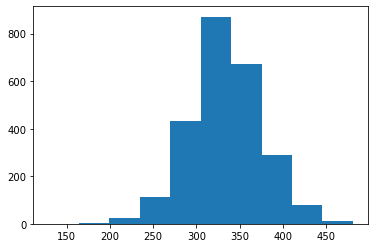

In [17]:
plt.figure()
plt.hist(df['Sulfate'])
plt.show()

In [18]:
df['Sulfate'].isna().sum()

781

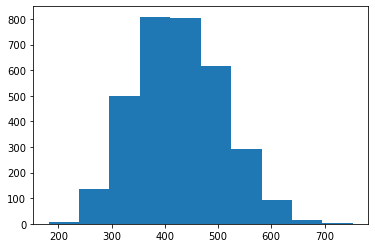

In [19]:
plt.figure()
plt.hist(df['Conductivity'])
plt.show()

In [20]:
df['Conductivity'].isna().sum()

0

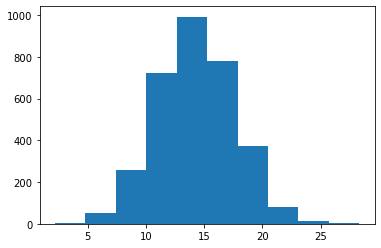

In [21]:
plt.figure()
plt.hist(df['Organic_carbon'])
plt.show()

In [22]:
df['Organic_carbon'].isna().sum()

0

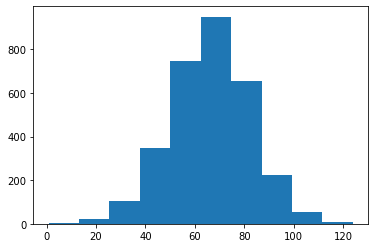

In [23]:
plt.figure()
plt.hist(df['Trihalomethanes'])
plt.show()

In [24]:
df['Trihalomethanes'].isna().sum()

162

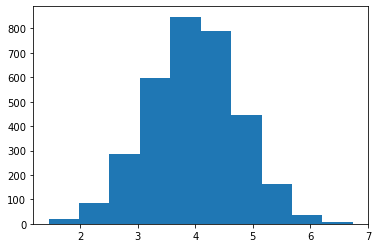

In [25]:
plt.figure()
plt.hist(df['Turbidity'])
plt.show()

In [26]:
df['Turbidity'].isna().sum()

0

In [27]:
df.isna().sum(axis=1).sort_values(ascending=False).head(10)

387     3
2065    3
3067    3
141     3
929     3
992     3
3062    3
201     3
646     3
1456    2
dtype: int64

In [28]:
df.isna().sum(axis=1).value_counts()

0    2011
1    1105
2     151
3       9
dtype: int64

Notes: All features appear relatively normally distributed with no apparent outliers. However, the scale on each feature is vastly different so some sort of normalization or standardization will be necessary (if using an algorithm that is sensitive to scale) - algorithms like decisions trees would not be impacted. The downside of scaling observations is that new observations will need to be scaled in the same way before generating an inference.

In addition, out of 3276 observations, the following columns had missing values:

- ph: 491
- Sulfate: 781
- Trihalomethanes: 162

In order to test for causes of missing values, we looked at how many missing values each row had. The majority of rows with any missing values only had one missing value. Only 151 had 2 missing values and only 9 rows had 3 missing values. This implies that the missingness is random.

Considering how small our original dataset is, we do not want to remove rows with missing values. Instead, we will choose to impute using the mean (since the features have what appears to be a normal distribution).

### Data Preparation

#### Step 1: Impute with mean

In [29]:
df_imputed = df.fillna(df.mean(), inplace=False)

#### Step 2: Normalize all features
Note: this will need to be done to new data before inference! I don't think this is a good practice because we would need to use the same Scaler object (because it is first fit to the data) and that would most likely not be available at the time of inference.

In [30]:
from sklearn.preprocessing import MinMaxScaler

np_scaled = MinMaxScaler().fit_transform(df_imputed)

df_scaled = pd.DataFrame(np_scaled, columns = df_imputed.columns)
df_scaled.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,0.505771,0.571139,0.336096,0.543891,0.680385,0.669439,0.313402,0.699753,0.286091,0.0
1,0.265434,0.297400,0.300611,0.491839,0.581699,0.719411,0.497319,0.450999,0.576793,0.0
2,0.578509,0.641311,0.321619,0.698543,0.581699,0.414652,0.562017,0.532866,0.303637,0.0
3,0.594055,0.605536,0.356244,0.603314,0.647347,0.317880,0.622089,0.808065,0.601015,0.0
4,0.649445,0.484851,0.289922,0.484900,0.514545,0.379337,0.358555,0.253606,0.496327,0.0


In [31]:
# note: data_class can either be train, test, or validation, prefix can either be 'preprocessed' or 'preprocessed_normalized'
def write_data_to_s3(df, prefix, data_class):
    prefix = '{}/{}'.format(prefix, data_class)
    key = 'water_quality.csv'
    s3_output = 's3://{}/{}/{}'.format(bucket, prefix, key)
    df.to_csv(s3_output, header=False, index=False)

In [32]:
# put target column first
df_scaled = pd.concat([df_scaled['Potability'], df_scaled.drop('Potability', axis=1, inplace=False)], axis=1)

In [33]:
df_scaled.head()

,Potability,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity
0,0.0,0.505771,0.571139,0.336096,0.543891,0.680385,0.669439,0.313402,0.699753,0.286091
1,0.0,0.265434,0.297400,0.300611,0.491839,0.581699,0.719411,0.497319,0.450999,0.576793
2,0.0,0.578509,0.641311,0.321619,0.698543,0.581699,0.414652,0.562017,0.532866,0.303637
3,0.0,0.594055,0.605536,0.356244,0.603314,0.647347,0.317880,0.622089,0.808065,0.601015
4,0.0,0.649445,0.484851,0.289922,0.484900,0.514545,0.379337,0.358555,0.253606,0.496327


In [34]:
# 60% train, 20% validate, 20% test
df_scaled_train, df_scaled_validation, df_scaled_test = \
                                                      np.split(df_scaled.sample(frac=1, random_state=42), 
                                                       [int(.6*len(df_scaled)), int(.8*len(df_scaled))])

In [35]:
df_scaled_train.shape

(1965, 10)

In [36]:
norm_prefix = 'preprocessed_normalized'
write_data_to_s3(df_scaled_train, norm_prefix, 'train')
write_data_to_s3(df_scaled_validation, norm_prefix, 'validation')

#### Step 2: Option 2 - Don't normalize features, use algorithm that is not sensitive to scale

- Decision trees - XGBoost

Put target variable as first column, split into train, test, validation

In [43]:
# put target column first
df_imputed = pd.concat([df_imputed['Potability'], df_imputed.drop('Potability', axis=1, inplace=False)], axis=1)

In [44]:
df_imputed.head()

,Potability,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity
0,0,7.080795,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135
1,0,3.716080,129.422921,18630.057858,6.635246,333.775777,592.885359,15.180013,56.329076,4.500656
2,0,8.099124,224.236259,19909.541732,9.275884,333.775777,418.606213,16.868637,66.420093,3.055934
3,0,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771
4,0,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075


In [45]:
# 60% train, 20% validate, 20% test
df_not_norm_train, df_not_norm_validation, df_not_norm_test = \
              np.split(df_imputed.sample(frac=1, random_state=42), 
                       [int(.6*len(df_imputed)), int(.8*len(df_imputed))])

In [46]:
df_not_norm_train.shape

(1965, 10)

In [47]:
not_norm_prefix = 'preprocessed'
write_data_to_s3(df_not_norm_train, not_norm_prefix, 'train')
write_data_to_s3(df_not_norm_validation, not_norm_prefix, 'validation')

### Modeling

#### Option 1: Normalized models

In [38]:
norm_output_path = 's3://{}/{}/output'.format(bucket, 'linear')

In [39]:
linear_container = sagemaker.image_uris.retrieve('linear-learner', region)

In [40]:
from sagemaker.inputs import TrainingInput

linear_estimator = sagemaker.estimator.Estimator(image_uri = linear_container,
                                                role = sagemaker.get_execution_role(),
                                                instance_count = 1,
                                                instance_type = 'ml.m4.xlarge',
#                                                 instance_type = 'local',
                                                volume_size = 5,
                                                output_path = norm_output_path)

linear_estimator.set_hyperparameters(predictor_type = 'binary_classifier')

content_type = "text/csv"
norm_train_input = TrainingInput('s3://{}/{}/{}/'.format(bucket, norm_prefix, 'train'), content_type=content_type)
norm_validation_input = TrainingInput('s3://{}/{}/{}/'.format(bucket, norm_prefix, 'validation'), content_type=content_type)

In [41]:
linear_metric = 'validation:binary_classification_accuracy'

In [ ]:
# testing out adding a test channel to the fit() method
write_data_to_s3(df_scaled_test, norm_prefix, 'test')
norm_test_input = TrainingInput('s3://{}/{}/{}/'.format(bucket, norm_prefix, 'test'), content_type = content_type)
linear_estimator.fit({'train': norm_train_input, 'validation': norm_validation_input, 'test': norm_test_input})

In [ ]:
# try fitting without hyperparameter optimization
linear_estimator.fit({'train': norm_train_input, 'validation': norm_validation_input})

In [104]:
from sagemaker.parameter import IntegerParameter, ContinuousParameter, CategoricalParameter
from sagemaker.tuner import HyperparameterTuner
from datetime import datetime

linear_hyperparameters = {
    'wd': ContinuousParameter(1e-7, 1),
    'l1': ContinuousParameter(1e-7, 1),
    'learning_rate': ContinuousParameter(1e-5, 1),
    'mini_batch_size': IntegerParameter(100, 1000),
    'use_bias': CategoricalParameter([True, False]),
    'positive_example_weight_mult': ContinuousParameter(1e-5, 1e5)
}

tuner_job_name = 'linear-learner-tuner-' + datetime.now().strftime("%m-%d-%H-%M-%S")

linear_tuner = HyperparameterTuner(estimator = linear_estimator,
                                    hyperparameter_ranges = linear_hyperparameters,
                                    base_tuning_job_name = tuner_job_name,
                                    objective_metric_name = linear_metric, 
                                    max_jobs = 6,
                                    max_parallel_jobs = 2)

In [105]:
linear_tuner.fit({'train': norm_train_input, 'validation': norm_validation_input})

..................................................................................................................................................................!


#### Option 2: Not normalized models

In [48]:
output_path = 's3://{}/{}/output'.format(bucket, 'xgboost')

In [49]:
xgboost_container = sagemaker.image_uris.retrieve("xgboost", region, "1.3-1")

In [50]:
from sagemaker.inputs import TrainingInput

# construct a SageMaker estimator that calls the xgboost-container
xgboost_estimator = sagemaker.estimator.Estimator(image_uri=xgboost_container, 
                                          role=sagemaker.get_execution_role(),
                                          instance_count=1, 
                                          instance_type='ml.m4.xlarge', 
                                          volume_size=5, # 5 GB 
                                          output_path=output_path)

xgboost_estimator.set_hyperparameters(num_round=20, objective='binary:logistic')

# define the data type and paths to the training and validation datasets
content_type = "text/csv"
train_input = TrainingInput("s3://{}/{}/{}/".format(bucket, not_norm_prefix, 'train'), content_type=content_type)
validation_input = TrainingInput("s3://{}/{}/{}/".format(bucket, not_norm_prefix, 'validation'), content_type=content_type)

In [52]:
# try fitting without hyperparameter tuning
xgboost_estimator.fit({'train': train_input, 'validation': validation_input})

2021-08-27 19:25:54 Starting - Starting the training job...
2021-08-27 19:26:23 Starting - Launching requested ML instancesProfilerReport-1630092354: InProgress
......
2021-08-27 19:27:23 Starting - Preparing the instances for training.........
2021-08-27 19:28:44 Downloading - Downloading input data
2021-08-27 19:28:44 Training - Downloading the training image.....[2021-08-27 19:29:29.331 ip-10-0-145-17.us-west-2.compute.internal:1 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2021-08-27:19:29:29:INFO] Imported framework sagemaker_xgboost_container.training
[2021-08-27:19:29:29:INFO] Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
[2021-08-27:19:29:29:INFO] No GPUs detected (normal if no gpus installed)
[2021-08-27:19:29:29:INFO] Running XGBoost Sagemaker in algorithm mode
[2021-08-27:19:29:29:INFO] Determined delimiter of CSV input is ','
[2021-08-27:19:29:29:INFO] Determined delimiter of CSV input is ','
[2021-08-27:19:29:2

In [119]:
from sagemaker.parameter import IntegerParameter, ContinuousParameter, CategoricalParameter
from sagemaker.tuner import HyperparameterTuner
from datetime import datetime

hyperparameter_ranges = {
    'alpha': ContinuousParameter(0, 1000),
    'min_child_weight': ContinuousParameter(0, 120),
    'subsample': ContinuousParameter(0.5, 1),
    'eta': ContinuousParameter(0.1, 0.5),
    'num_round': IntegerParameter(1, 4000)
}

tuner_job_name = 'xgboost-tuner-' + datetime.now().strftime("%m-%d-%H-%M-%S")

tuner = HyperparameterTuner(estimator=xgboost_estimator, base_tuning_job_name=tuner_job_name,
                                objective_metric_name=metric,
                                hyperparameter_ranges=hyperparameter_ranges,
                                max_jobs=6, max_parallel_jobs=2)

tuner.fit({'train': train_input, 'validation': validation_input})

......................................................................................................................................................................!
